Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [43]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [44]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [45]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [46]:
# Trainig Datasets 
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [47]:
# Validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [48]:
# List of all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
creating a code to visualize one instance of all the nine classes present in the dataset

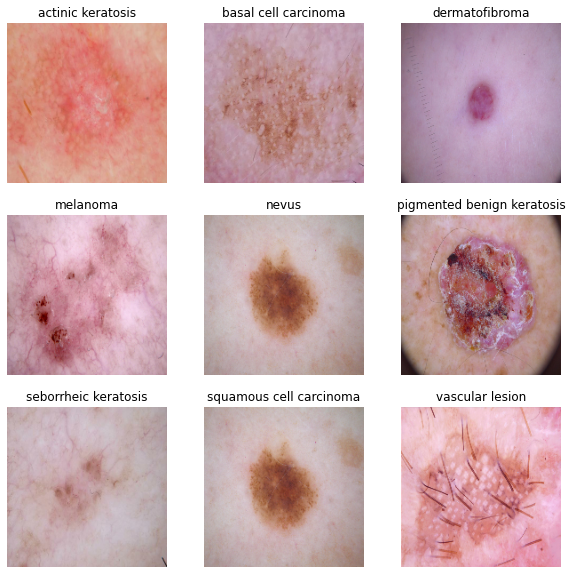

In [49]:
import matplotlib.pyplot as plt

### training or validation data to visualize
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    
    new_ds=train_ds.filter(lambda x, l : tf.math.equal(l[0],i))
    
    for images, labels in new_ds.take(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy()[0]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Creating a CNN model, which can accurately detect 9 classes present in the dataset. 

In [51]:

num_classes = 9

model=Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))
                  ])
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu',input_shape=(180,180,32)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))




### Compile the model
Here "Adam" an appropirate optimiser and "SparseCategoricalCrossentropy" loss function for model training 

In [52]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_21 (ModuleWr  (None, 180, 180, 32)     2432      
 apper)                                                          
                                                                 
 module_wrapper_22 (ModuleWr  (None, 180, 180, 32)     25632     
 apper)                                                          
                                                                 
 module_wrapper_23 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_24 (ModuleWr  (None, 90, 90, 32)       25632     
 apper)                                               

### Train the model

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 25s 45ms/step - loss: 2.1794 - accuracy: 0.1486 - val_loss: 2.2035 - val_accuracy: 0.0435
Epoch 2/20
169/169 [==============================] - 7s 39ms/step - loss: 2.1260 - accuracy: 0.1881 - val_loss: 2.1139 - val_accuracy: 0.3478
Epoch 3/20
169/169 [==============================] - 7s 40ms/step - loss: 1.8136 - accuracy: 0.3145 - val_loss: 2.1095 - val_accuracy: 0.3043
Epoch 4/20
169/169 [==============================] - 7s 39ms/step - loss: 1.5460 - accuracy: 0.4316 - val_loss: 1.9101 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 7s 39ms/step - loss: 1.3201 - accuracy: 0.5152 - val_loss: 2.3104 - val_accuracy: 0.3478
Epoch 6/20
169/169 [==============================] - 7s 40ms/step - loss: 1.1337 - accuracy: 0.5912 - val_loss: 2.7520 - val_accuracy: 0.2174
Epoch 7/20
169/169 [==============================] - 7s 39ms/step - loss: 0.9540 - accuracy: 0.6588 - val_loss: 3.0633 - val_accuracy: 0.347

### Visualizing training results

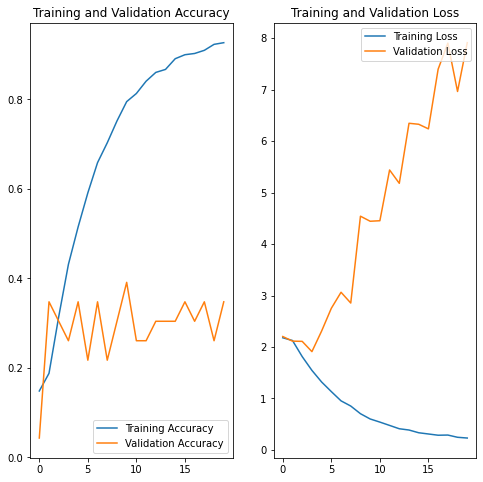

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Write your findings after the model fit, see if there is an evidence of model overfit or underfit


#### Insight: 
- From above graphs we can describe that for training and validation are not matched to each other. The training accuracy  is high as compare to the validation accuracy.So we can say that model is overfitted.Also validation loss is very high.
- We have used base model architecture which is not at all sufficient for the classification problem.
- With other modifications such as adding dropouts, augmentation, and increasing the size of the data the model can perform better.

### Write your findings here

In [56]:
df_aug=keras.Sequential([
                           layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                           layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),
                           layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode='reflect')])

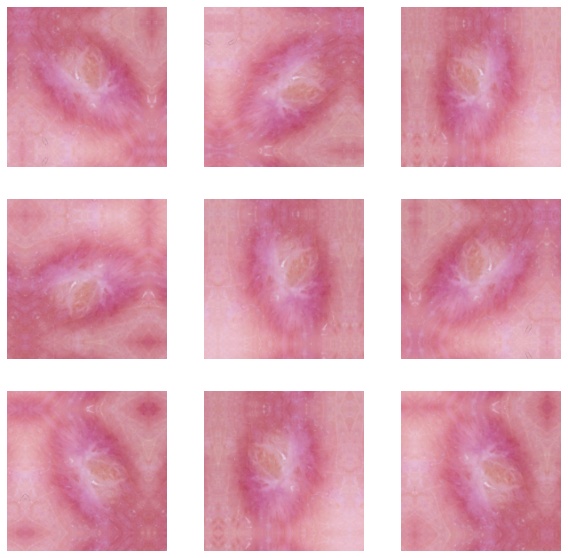

In [57]:
#  Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
    for i in range(9):
        aug_images= df_aug(images)
        ax= plt.subplot(3,3,i+1)
        plt.imshow(aug_images[0].numpy().astype('uint8'))
        plt.axis('off')


### Create the model, compile and train the model

In [58]:
## We use Dropout layer if there is an evidence of overfitting in our findings

num_classes = 9
model = Sequential([ df_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [59]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [60]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 9s 43ms/step - loss: 2.1884 - accuracy: 0.1371 - val_loss: 2.1870 - val_accuracy: 0.0870
Epoch 2/20
169/169 [==============================] - 7s 42ms/step - loss: 2.1109 - accuracy: 0.1869 - val_loss: 2.0922 - val_accuracy: 0.1739
Epoch 3/20
169/169 [==============================] - 7s 42ms/step - loss: 1.9668 - accuracy: 0.2433 - val_loss: 2.1204 - val_accuracy: 0.2174
Epoch 4/20
169/169 [==============================] - 7s 42ms/step - loss: 1.7665 - accuracy: 0.3023 - val_loss: 1.9436 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 7s 42ms/step - loss: 1.6942 - accuracy: 0.3466 - val_loss: 2.0968 - val_accuracy: 0.1739
Epoch 6/20
169/169 [==============================] - 7s 42ms/step - loss: 1.5697 - accuracy: 0.3978 - val_loss: 2.0467 - val_accuracy: 0.3043
Epoch 7/20
169/169 [==============================] - 7s 42ms/step - loss: 1.5298 - accuracy: 0.4149 - val_loss: 1.9936 - val_accuracy: 0.2609

### Visualizing the results

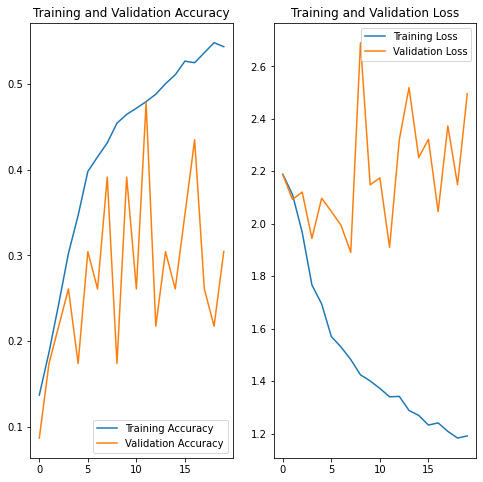

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Insights:
- Here we can depict that after base model has high accuracy that above model.But in current model accuracy between training and validation data become reduce.
- Also accuracy of training data is high than validation data which is indicating still overfitting.
- If the dropout values, layers, etc. are optimized at various levels, this model can perform better.

In [62]:
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

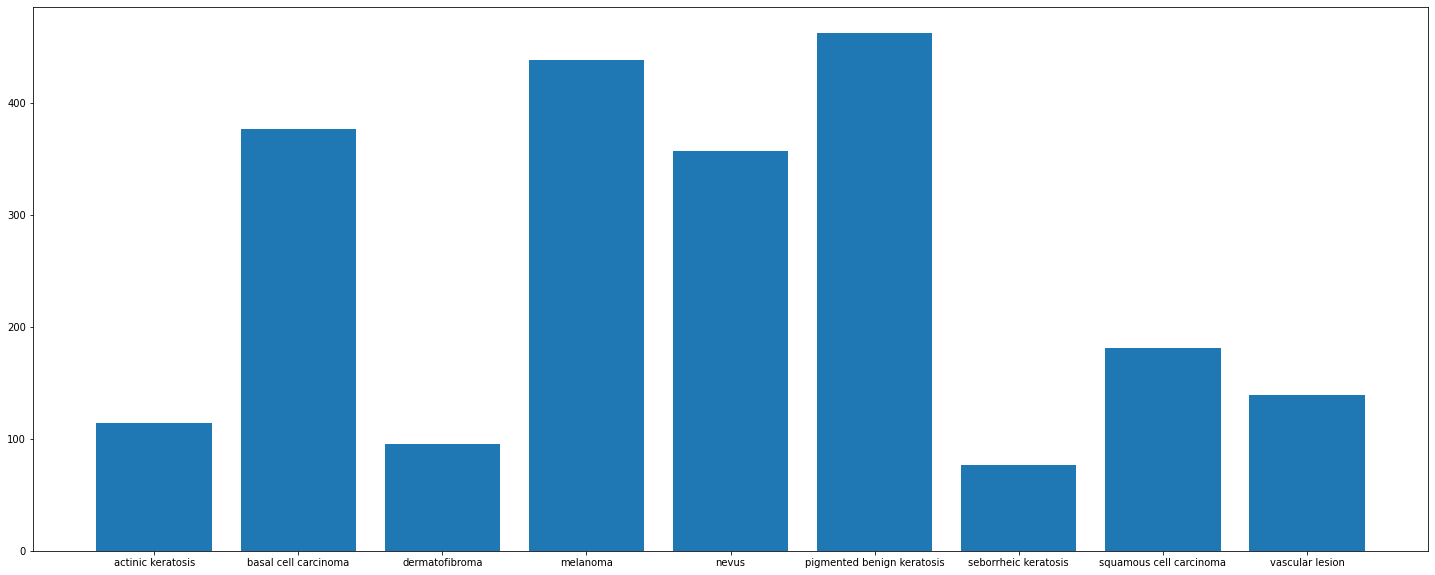

In [63]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


### Insights

- **Seborrheic keratosis** has the least number of samples. Apart from it **dermatofibroma** and **actinic keratosis** are also less in numbers of samples.

- **Pigmented Benign keratosis**,**melanoma**,**basal cell carcinoma** classes dominate the data in terms proportionate numbers of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [64]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [65]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84365F1190>: 100%|██████████| 500/500 [00:10<00:00, 48.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8435DAF550>: 100%|██████████| 500/500 [00:40<00:00, 12.50 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8431854E90>: 100%|██████████| 500/500 [00:10<00:00, 45.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F8432E10A50>: 100%|██████████| 500/500 [00:49<00:00, 10.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F8431846810>: 100%|██████████| 500/500 [00:44<00:00, 11.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8431797150>: 100%|██████████| 500/500 [00:10<00:00, 47.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F84316E0FD0>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8431775890>: 100%|██████████| 500/500 [00:10<00:00, 47.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84367ACDD0>: 100%|██████████| 500/500 [00:10<00:00, 46.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [66]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [67]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028816.jpg_f73e0ca6-5342-4e1e-a573-7a10b3893554.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_9b274c1e-de73-419f-9ac1-8f5b17c2f107.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028232.jpg_e1239142-a3c9-446f-97d7-b7d05bb7b669.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030297.jpg_0ffec177-3ab2-4a78-af0f-f3c99abd0d7c.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squ

In [68]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [69]:
path_list_new=path_list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [70]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [71]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [72]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [73]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [74]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [75]:
## your code goes here

model = Sequential([
  df_aug,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.BatchNormalization(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),


  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.3),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])




#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [76]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [77]:

## Your code goes here, use 50 epochs.

epochs=50
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 38s 124ms/step - loss: 1.6794 - accuracy: 0.4002 - val_loss: 2.9699 - val_accuracy: 0.2176
Epoch 2/50
281/281 [==============================] - 35s 123ms/step - loss: 1.3331 - accuracy: 0.4884 - val_loss: 1.1968 - val_accuracy: 0.5452
Epoch 3/50
281/281 [==============================] - 35s 123ms/step - loss: 1.2229 - accuracy: 0.5234 - val_loss: 1.1083 - val_accuracy: 0.5683
Epoch 4/50
281/281 [==============================] - 35s 120ms/step - loss: 1.1534 - accuracy: 0.5585 - val_loss: 1.3058 - val_accuracy: 0.5234
Epoch 5/50
281/281 [==============================] - 35s 122ms/step - loss: 1.0801 - accuracy: 0.5836 - val_loss: 1.1233 - val_accuracy: 0.5883
Epoch 6/50
281/281 [==============================] - 35s 121ms/step - loss: 1.0337 - accuracy: 0.6029 - val_loss: 1.3872 - val_accuracy: 0.5229
Epoch 7/50
281/281 [==============================] - 35s 121ms/step - loss: 0.9904 - accuracy: 0.6098 - val_loss: 0.9930 - val_ac

#### **Todo:**  Visualize the model results

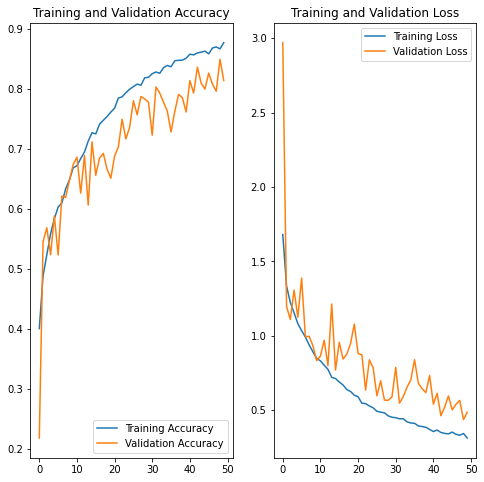

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

71/71 [==============================] - 7s 85ms/step - loss: 0.4845 - accuracy: 0.8140
Accuracy:  0.8429715037345886
Validation Accuracy:  0.8139742016792297
Loss:  0.3949727714061737
Validation Loss 0.484483003616333


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


- From above model we can describe that model performance in terms of training as well as validation accuracy are increasing with epochs, it shows good results.Ideally Batch Normalization helps to reduce the overfitting.

- From the class rebalance we are able to reduce overfititng of the data and also the losses are gradually reducing.

- Initially we have used model without the ImageDataGenerator,which results in overfitting, then have used dropout and ImageDataGenerator which reduce overfiiting.And from Batch Normalization and Data Augumentation overfitting reduce drastically